# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
def stream[F[_]: cats.effect.kernel.Async](u: org.http4s.Uri): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, bearerToken))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
object IsObject: 
    def unapply(v: Json): Option[JsonObject] = 
        v.asObject

In [ ]:
object IsString: 
    def unapply(v: Json): Option[String] = 
        v.asString

In [ ]:
def allCommitPages[F[_]: Async](repo: String): Stream[F, Json] =

    def newPage(i: Int): Stream[F, Json] = 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"))
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

In [ ]:
extension [A](st: Stream[IO, A])
    def run: List[A] = 
        st.compile.toList.unsafeRunSync()

# How to embed `jq`?

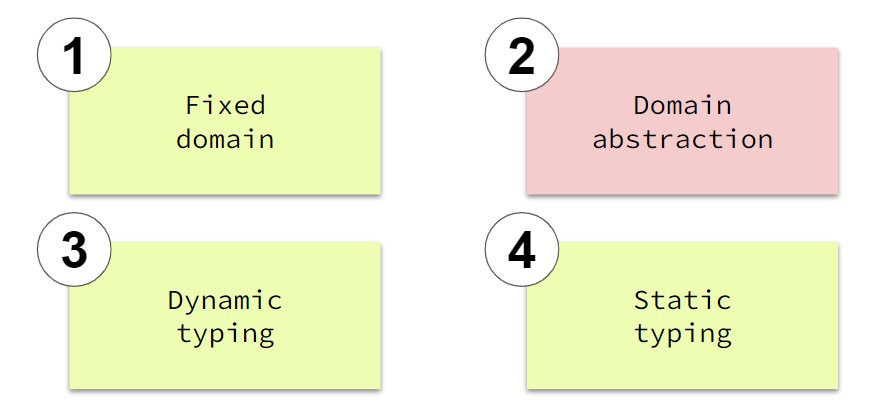

### Abstraction through type-classes

In [ ]:
trait Jq[R]: 

    /* Primitive Filters */

    def id: R
    def str(s: String): R
    def iterator: R
    def array(f: R): R

    extension (f1: R)
        def |(f2: R): R
        def concat(f2: R): R
        def index(f2: R): R

    /* built-in functions */

    def map(f: R): R = 
        array(iterator | f)

object Jq: 

    def apply[R](using J: Jq[R]): Jq[R] = J

    object syntax: 
        def iterator[R: Jq]: R = Jq[R].iterator 

        def arr[R](f: R*)(using J: Jq[R]): R = 
            J.array(f.reduce(_ concat _))

        extension [R](sc: StringContext)(using J: Jq[R])
            def i(args: R*): R = 
                sc.s().split('.').toList.map(key => J.id.index(J.str(key))).reduce(_ | _)

### Semantics through `given` instances

In [ ]:
object Fs2:

    type Filter[F[_]] = Pipe[F, Json, Json] 

    given [F[_]]: Jq[Filter[F]] with 

        def id: Filter[F] = 
            identity[Stream[F, Json]]

        def str(s: String): Filter[F] = 
            _ map: _ => 
                Json.fromString(s)

        def iterator: Filter[F] = 
            _ flatMap: 
                case IsArray(v) => Stream(v*)
                case _ => Stream(Json.Null)

        extension (f1: Filter[F])

            def |(f2: Filter[F]): Filter[F] = 
                _ flatMap: json => 
                    f1(Stream(json)).flatMap: json2 => 
                        f2(Stream(json2)) 

            def concat(f2: Filter[F]): Filter[F] = 
                _ flatMap: json => 
                    f1(Stream(json)) ++ f2(Stream(json))

            private def indexObj(key: String)(v: Json): Stream[F, Json] = 
                f1(Stream(v)). map:
                    case IsObject(obj) => obj(key).getOrElse(Json.Null)
                    case _ => Json.Null

            def index(f2: Filter[F]): Filter[F] = 
                _.flatMap: v => 
                    f2(Stream(v)) flatMap:
                        case IsString(s) => indexObj(s)(v)
                        case _ => Stream(Json.Null)

        def array(f: Filter[F]): Filter[F] = 
            _ flatMap: json => 
                f(Stream(json))
                    .fold(List[Json]())(_ :+ _)
                    .map(Json.arr(_*))

In [ ]:
import Fs2.given, Jq.syntax._

In [ ]:
def extractInfo[F[_]]: Pipe[F, Json, Json] = 
    iterator | arr(i"author.login", i"commit.author.date")

### Ad-hoc polymorphic programs

##### Ad-hoc polymorphic methods

In [ ]:
def extractInfo[R: Jq]: R = 
    iterator | arr(i"author.login", i"commit.author.date")

##### Using polymorphic & context function types

In [ ]:
val extractInfo: [R] => Jq[R] ?=> R = 
    [R] => (_ : Jq[R]) ?=> 
        iterator | arr(i"author.login", i"commit.author.date")

# References

* Scala 3: type classes: https://docs.scala-lang.org/scala3/reference/contextual/type-classes.html
* Church encoding: https://okmij.org/ftp/tagless-final/course/Boehm-Berarducci.html